## Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import math
import random

## Functions

In [2]:
size = 100


def generate_points(n, distribution, mu=(size//2, size//2), sigma=(5 * np.identity(2))):
    """generating random points"""
    if distribution == "uniform":
        points = np.random.uniform((0, 0), (size, size), (n, 2))
    elif distribution == "normal":
        points = np.random.multivariate_normal(mu, sigma, n)
    elif distribution == "separated":
        points = np.zeros((n, 2))
        possible_places = [x for x in range(0, 25)]

        for i in range(9):
            place = random.choice(possible_places)
            possible_places.remove(place)
            for k in range((i * n) // 9, ((i+1) * n) // 9):
                curr_mu = ((size / 5) * (place // 5) + size/10, (size / 5) * (place % 5) + size/10)
                points[k] = np.random.multivariate_normal(curr_mu, sigma, 1)
    else:
        points = [[]]

    return points


def dist(a, b):
    """distance between two points in Euclidean metric"""
    return math.sqrt((b[0] - a[0])**2 + (b[1] - a[1])**2)


def get_cost(points):
    """getting distance for current sequence of points"""
    n = points.shape[0]
    cost = 0
    for i in range(n):
        cost += dist(points[i], points[(i + 1) % n])

    return cost


def anneal(points, t_max, multiplier, iterations, second_random=False):
    """simulated annealing"""
    
    # frames to animate path changing
    frames = [points]

    optimal_points = points.copy()
    n = points.shape[0]

    # frames to animate cost function
    cost = get_cost(points)
    costs = [(0, cost)]

    it = 1
    t = t_max
    while it < iterations:
        # getting random points to swap them
        point1_to_swap = random.randint(0, n - 1)
        point2_to_swap = random.randint(0, n - 1) if second_random else (point1_to_swap + 1) % n
        if point1_to_swap == point2_to_swap:
            point2_to_swap = (point2_to_swap + 1) % n

        # swapping points
        new_permutation = optimal_points.copy()
        new_permutation[[point1_to_swap, point2_to_swap]] = new_permutation[[point2_to_swap, point1_to_swap]]

        # getting distance for new sequence of points
        new_cost = get_cost(new_permutation)

        # checking if current optimal points will be updated
        if new_cost < cost or math.e ** ((cost - new_cost) / t) > random.random():
            optimal_points = new_permutation
            cost = new_cost
            frames.append(new_permutation)
            costs.append((it, new_cost))

        it += 1
        t *= multiplier
        
    frames.append(optimal_points)
    costs.append((it, cost))

    return optimal_points, frames, costs

## Animation

In [13]:
def get_animation(t_max, multiplier, iterations, arbitrary, points):
    # plot configurations
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    fig.tight_layout(pad=3.0)
    
    # annealing
    points, frames, costs = anneal(points, t_max, multiplier, iterations, arbitrary)

    # preparing plot for path for the travelling salesman
    path, = ax[0].plot([], [], 'b-')
    ax[0].scatter(points[:, 0], points[:, 1], c="#FF0000")
    ax[0].set_xlim(0, 100)
    ax[0].set_ylim(0, 100)
    ax[0].set_title("Path for salesman")
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    # preparing plot for the cost (distance) function
    cost_line, = ax[1].plot([], [], 'r-')
    ax[1].set_xlim(0, iterations)
    ax[1].set_ylim(0, costs[0][1] * 2)
    ax[1].set_title("Distance")
    ax[1].set_xlabel("iterations")
    ax[1].set_ylabel("distance")
    xcost = []
    ycost = []

    # function called in every frame of animation
    def update_path(i):
        frame = frames[int(i)]
        xdata = frame[:, 0]
        ydata = frame[:, 1]

        xdata = np.append(xdata, xdata[0])
        ydata = np.append(ydata, ydata[0])

        xcost.append(costs[int(i)][0])
        ycost.append(costs[int(i)][1])

        path.set_data(xdata, ydata)

        cost_line.set_data(xcost, ycost)
        return path, cost_line
    
    # animation.FuncAnimation have to be called in other cell so all necessary variables are returned
    return plt, fig, update_path, frames

## Visualizations

### Uniform distribution

<IPython.core.display.Javascript object>


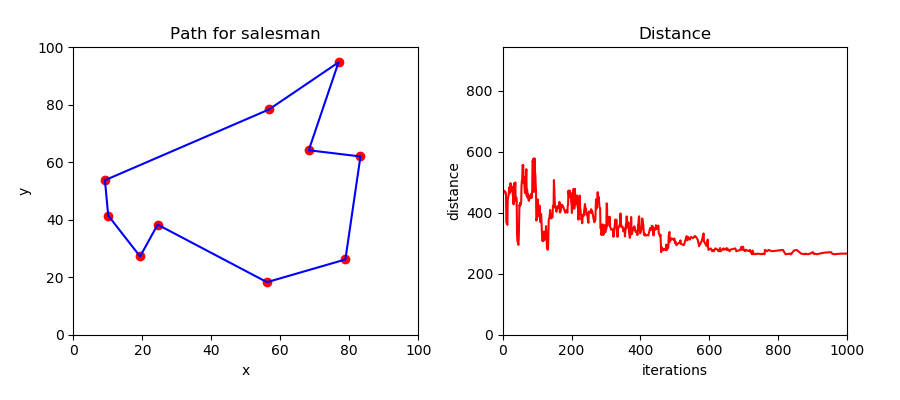

In [18]:
# CONSECUTIVE SWAP, N = 10

%matplotlib nbagg

t_max = 100
multiplier = 0.996
iterations = 1000
arbitrary = False

points = generate_points(10, "uniform")

plt, fig, update_path, frames = get_animation(t_max, multiplier, iterations, arbitrary, points)

_ = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                                  interval=1, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


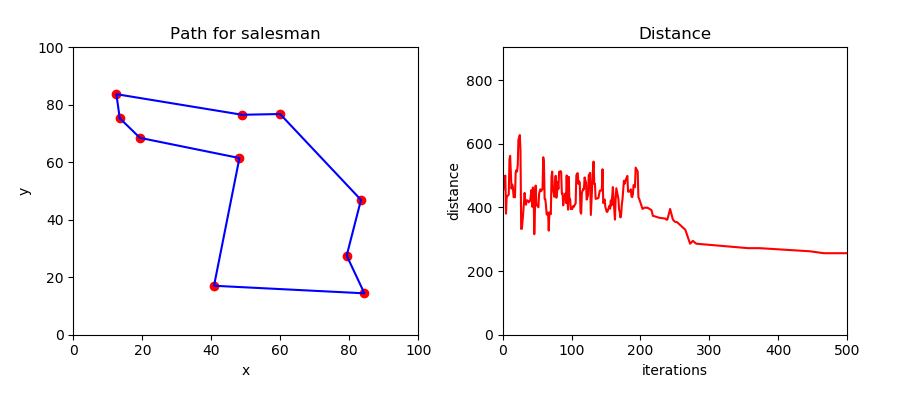

In [352]:
# ARBITRARY SWAP, N = 10

%matplotlib nbagg

t_max = 1000
multiplier = 0.98
iterations = 500
arbitrary = True

points = generate_points(10, "uniform")

plt, fig, update_path, frames = get_animation(t_max, multiplier, iterations, arbitrary, points)

_ = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                                  interval=1, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


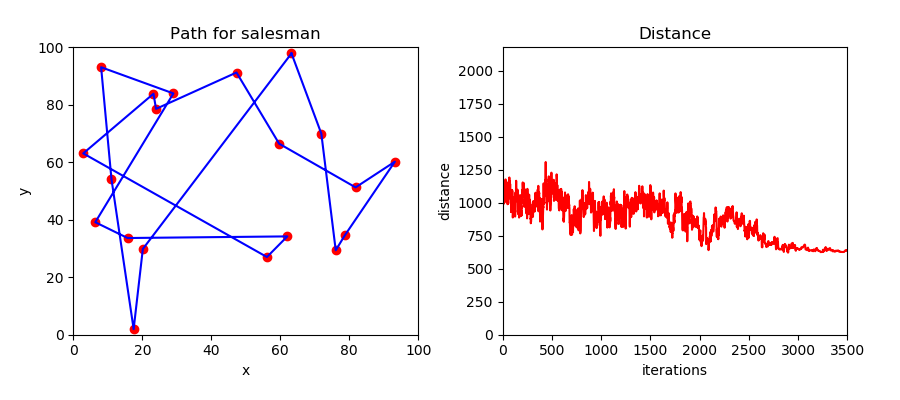

In [367]:
# CONSECUTIVE SWAP, N = 20

%matplotlib nbagg

t_max = 1000
multiplier = 0.9985
iterations = 3500
arbitrary = False

points = generate_points(20, "uniform")

plt, fig, update_path, frames = get_animation(t_max, multiplier, iterations, arbitrary, points)

_ = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                                  interval=1, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


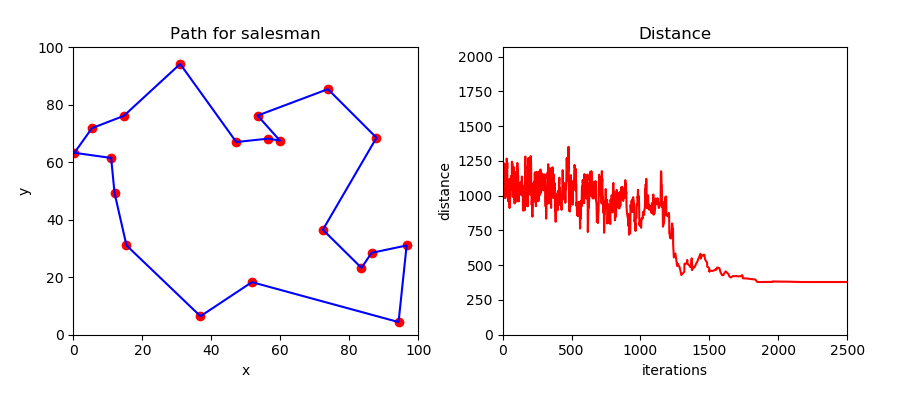

In [375]:
# ARBITRARY SWAP, N = 20

%matplotlib nbagg

t_max = 1000
multiplier = 0.997
iterations = 2500
arbitrary = True

points = generate_points(20, "uniform")

plt, fig, update_path, frames = get_animation(t_max, multiplier, iterations, arbitrary, points)

_ = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                                  interval=1, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


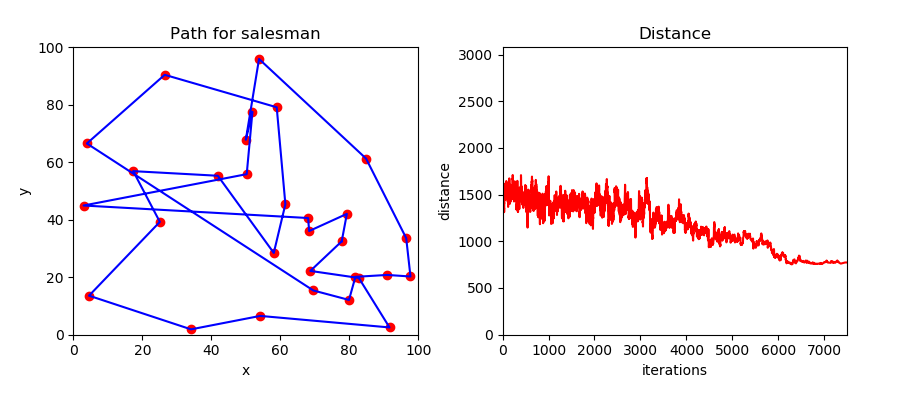

In [378]:
# CONSECUTIVE SWAP, N = 30

%matplotlib nbagg

t_max = 1000
multiplier = 0.9992
iterations = 7500
arbitrary = False

points = generate_points(30, "uniform")

plt, fig, update_path, frames = get_animation(t_max, multiplier, iterations, arbitrary, points)

_ = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                                  interval=1, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


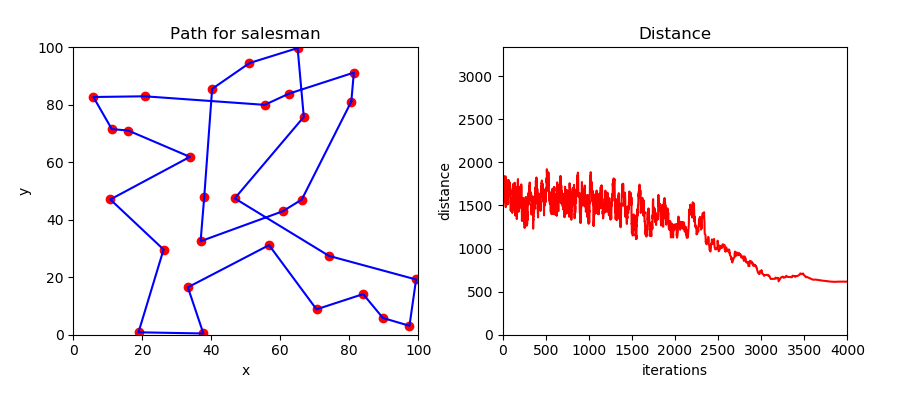

In [380]:
# ARBITRARY SWAP, N = 30

%matplotlib nbagg

t_max = 1000
multiplier = 0.9985
iterations = 4000
arbitrary = True

points = generate_points(30, "uniform")

plt, fig, update_path, frames = get_animation(t_max, multiplier, iterations, arbitrary, points)

_ = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                                  interval=1, repeat=False)

plt.show()

### Normal Distribution

<IPython.core.display.Javascript object>


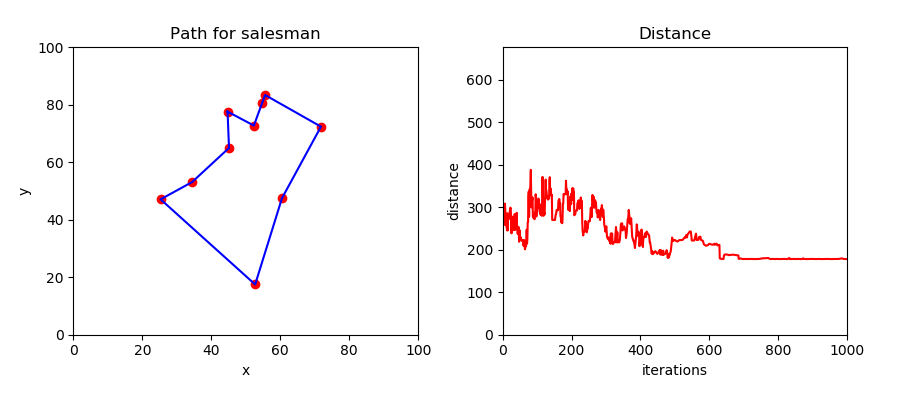

In [384]:
# CONSECUTIVE SWAP, N = 10
#
# matrix of covariance:
# (250 0)
# (0 250)

%matplotlib nbagg

t_max = 100
multiplier = 0.995
iterations = 1000
arbitrary = False

points = generate_points(10, "normal", sigma=np.array([[250,0],[0,250]]))

plt, fig, update_path, frames = get_animation(t_max, multiplier, iterations, arbitrary, points)

_ = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                                  interval=1, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


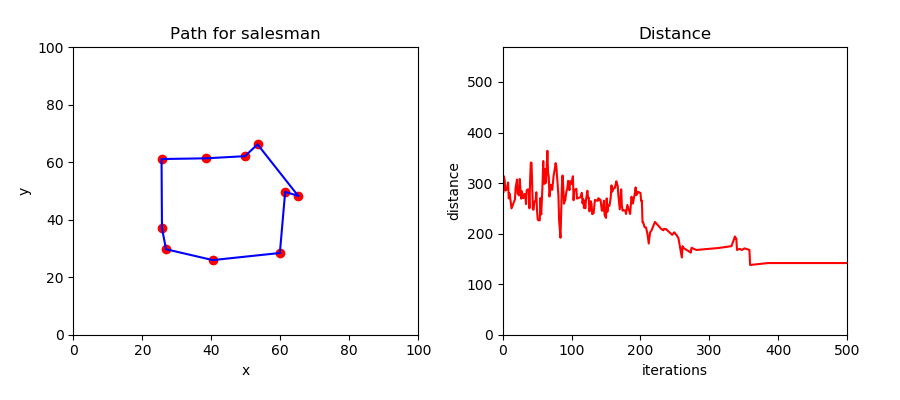

In [389]:
# ARBITRARY SWAP, N = 10
#
# matrix of covariance:
# (250 0)
# (0 250)

%matplotlib nbagg

t_max = 100
multiplier = 0.99
iterations = 500
arbitrary = True

points = generate_points(10, "normal", sigma=np.array([[250,0],[0,250]]))

plt, fig, update_path, frames = get_animation(t_max, multiplier, iterations, arbitrary, points)

_ = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                                  interval=1, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


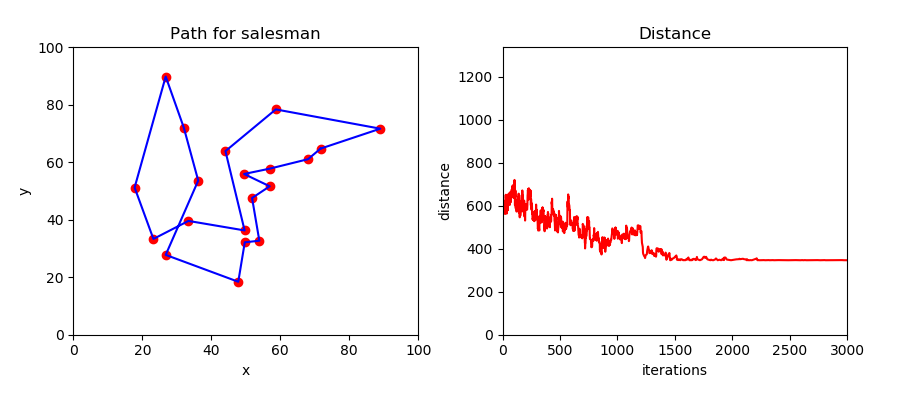

In [414]:
# CONSECUTIVE SWAP, N = 20
#
# covariance matrix:
# (250 10)
# (10 250)

%matplotlib nbagg

t_max = 100
multiplier = 0.998
iterations = 3000
arbitrary = False

points = generate_points(20, "normal", sigma=np.array([[250,10],[10,250]]))

plt, fig, update_path, frames = get_animation(t_max, multiplier, iterations, arbitrary, points)

_ = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                                  interval=1, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


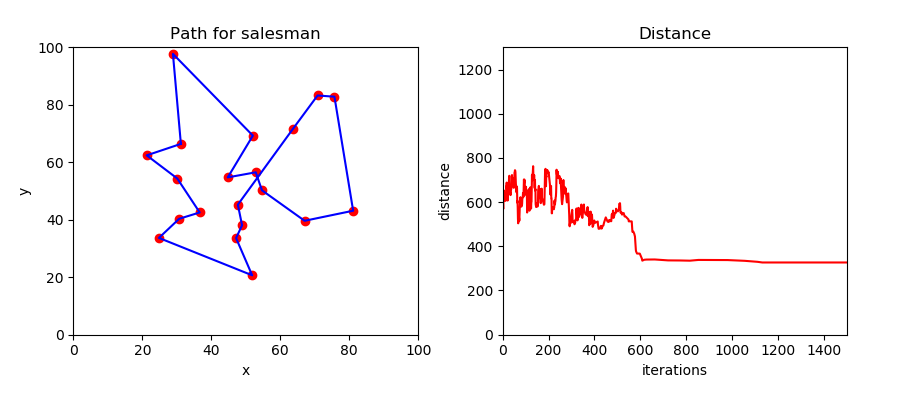

In [416]:
# ARBITRARY SWAP, N = 20
#
# matrix of covariance:
# (250 10)
# (10 250)

%matplotlib nbagg

t_max = 200
multiplier = 0.994
iterations = 1500
arbitrary = True

points = generate_points(20, "normal", sigma=np.array([[250,10],[10,250]]))

plt, fig, update_path, frames = get_animation(t_max, multiplier, iterations, arbitrary, points)

_ = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                                  interval=1, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


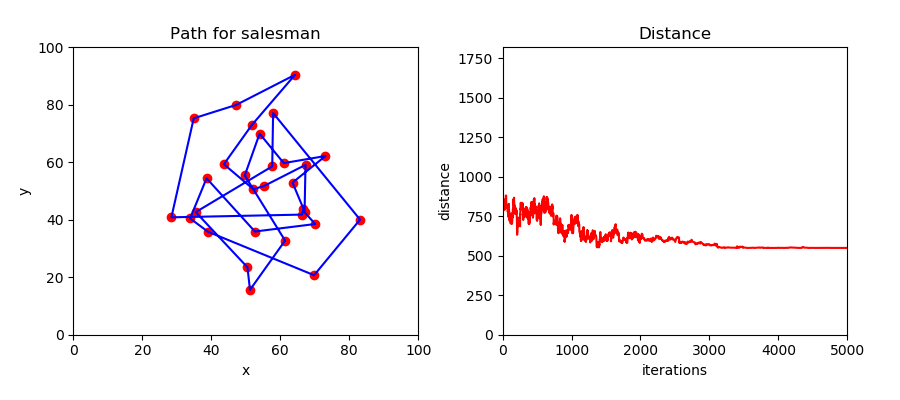

In [419]:
# CONSECUTIVE SWAP, N = 30
#
# matrix of covariance:
# (250 40)
# (40 250)
%matplotlib nbagg

t_max = 50
multiplier = 0.999
iterations = 5000
arbitrary = False

points = generate_points(30, "normal", sigma=np.array([[250,40],[40,250]]))

plt, fig, update_path, frames = get_animation(t_max, multiplier, iterations, arbitrary, points)

_ = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                                  interval=1, repeat=False)

plt.show()

Traceback (most recent call last):
  File "/home/sheldak/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/sheldak/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


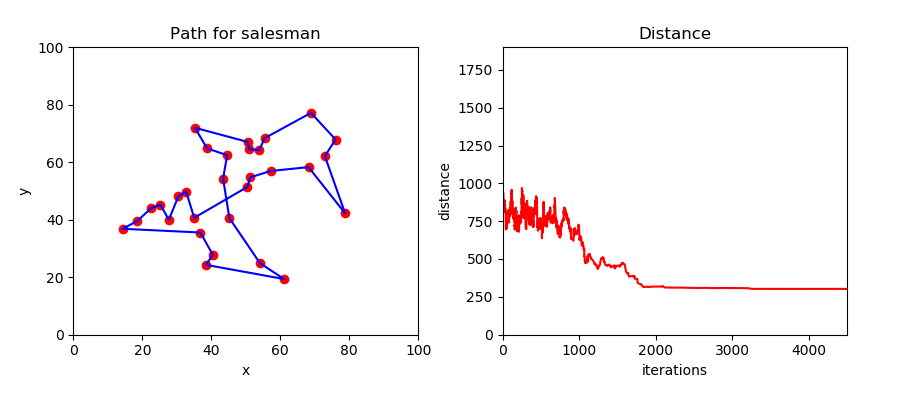

In [420]:
# ARBITRARY SWAP, N = 30
#
# matrix of covariance:
# (250 40)
# (40 250)
%matplotlib nbagg

t_max = 100
multiplier = 0.998
iterations = 4500
arbitrary = True

points = generate_points(30, "normal", sigma=np.array([[250,40],[40,250]]))

plt, fig, update_path, frames = get_animation(t_max, multiplier, iterations, arbitrary, points)

_ = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                                  interval=1, repeat=False)

plt.show()

/home/sheldak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: covariance is not positive-semidefinite.
  


<IPython.core.display.Javascript object>


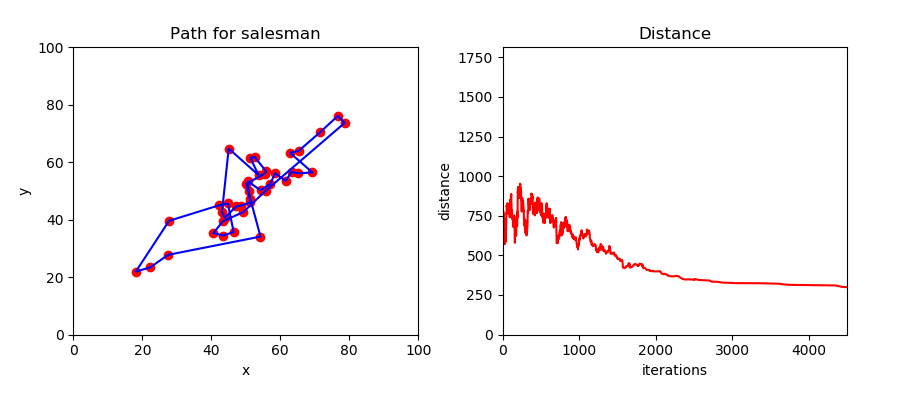

In [423]:
# ARBITRARY SWAP, N = 40
#
# matrix of covariance:
# (250 220)
# (220 250)
%matplotlib nbagg

t_max = 100
multiplier = 0.998
iterations = 4500
arbitrary = True

points = generate_points(40, "normal", sigma=np.array([[250,220],[200,220]]))

plt, fig, update_path, frames = get_animation(t_max, multiplier, iterations, arbitrary, points)

_ = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                                  interval=1, repeat=False)

plt.show()

### 9 separeted groups of points

<IPython.core.display.Javascript object>


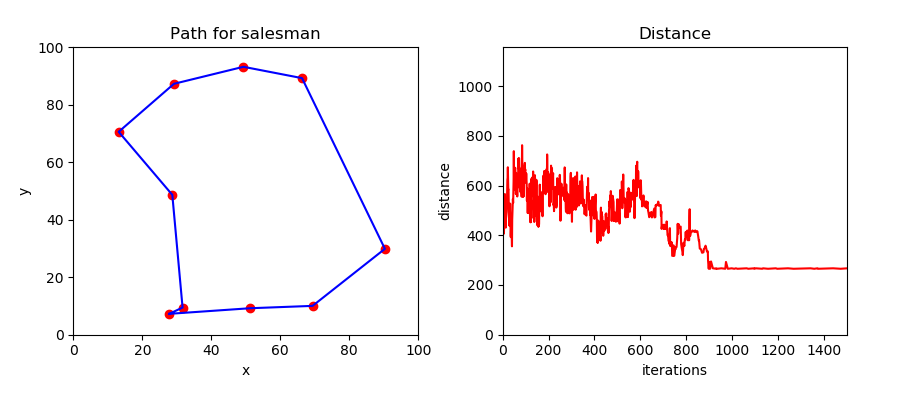

In [430]:
# CONSECUTIVE SWAP, N = 10

%matplotlib nbagg

t_max = 1000
multiplier = 0.995
iterations = 1500
arbitrary = False

points = generate_points(10, "separated")

plt, fig, update_path, frames = get_animation(t_max, multiplier, iterations, arbitrary, points)

_ = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                                  interval=1, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


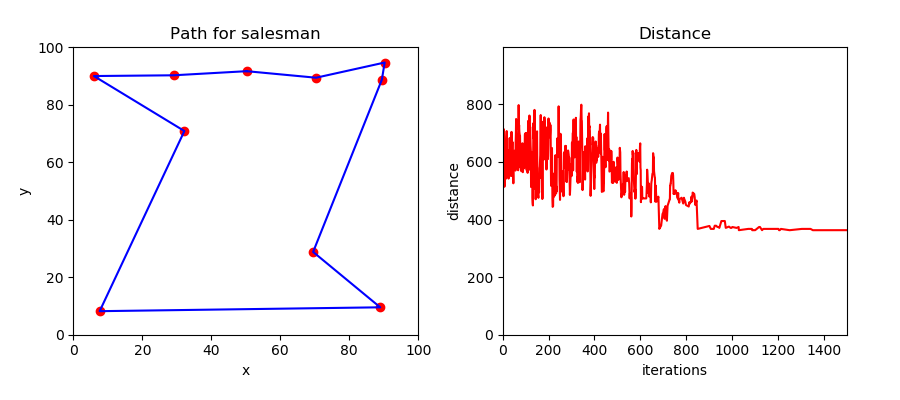

In [432]:
# ARBITRARY SWAP, N = 10

%matplotlib nbagg

t_max = 1000
multiplier = 0.995
iterations = 1500
arbitrary = True

points = generate_points(10, "separated")

plt, fig, update_path, frames = get_animation(t_max, multiplier, iterations, arbitrary, points)

_ = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                                  interval=1, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


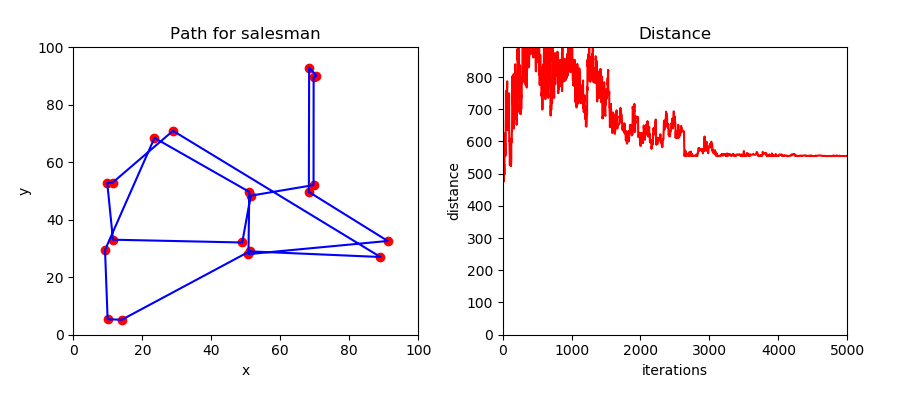

In [444]:
# CONSECUTIVE SWAP, N = 20

%matplotlib nbagg

t_max = 100
multiplier = 0.999
iterations = 5000
arbitrary = False

points = generate_points(20, "separated")

plt, fig, update_path, frames = get_animation(t_max, multiplier, iterations, arbitrary, points)

_ = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                                  interval=1, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


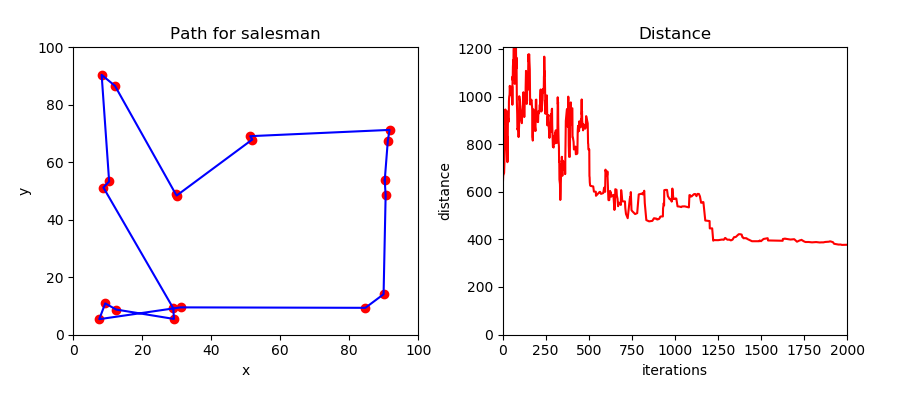

In [449]:
# ARBITRARY SWAP, N = 20

%matplotlib nbagg

t_max = 100
multiplier = 0.998
iterations = 2000
arbitrary = True

points = generate_points(20, "separated")

plt, fig, update_path, frames = get_animation(t_max, multiplier, iterations, arbitrary, points)

_ = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                                  interval=1, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


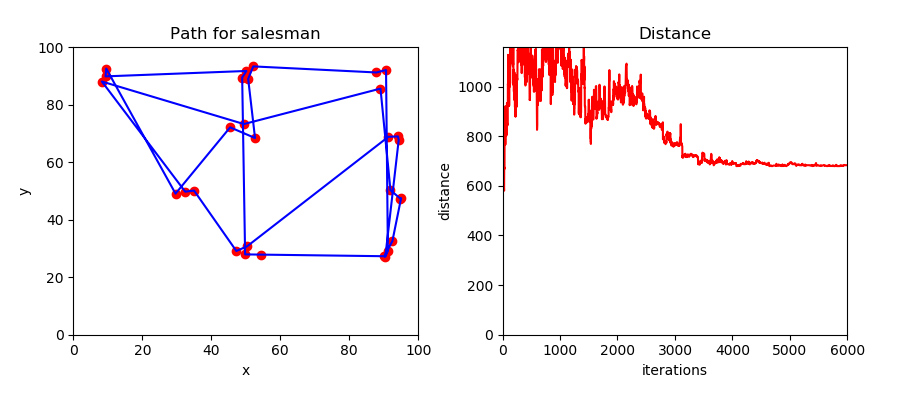

In [452]:
# CONSECUTIVE SWAP, N = 30

%matplotlib nbagg

t_max = 100
multiplier = 0.9992
iterations = 6000
arbitrary = False

points = generate_points(30, "separated")

plt, fig, update_path, frames = get_animation(t_max, multiplier, iterations, arbitrary, points)

_ = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                                  interval=1, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


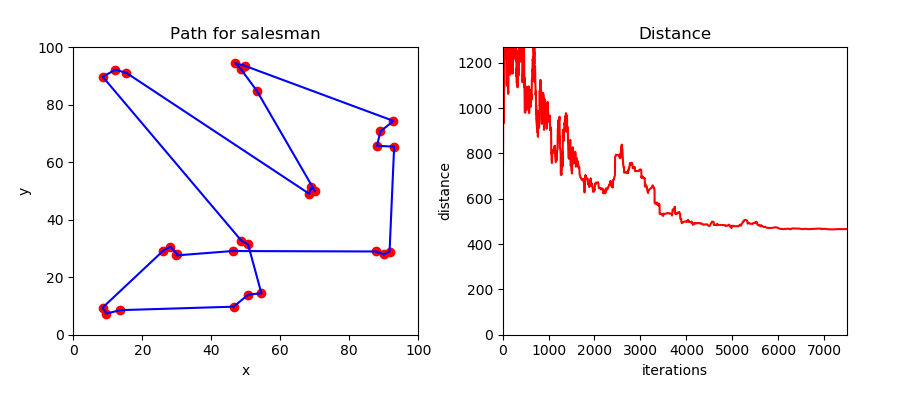

In [459]:
# ARBITRARY SWAP, N = 30

%matplotlib nbagg

t_max = 50
multiplier = 0.9994
iterations = 7500
arbitrary = True

points = generate_points(30, "separated")

plt, fig, update_path, frames = get_animation(t_max, multiplier, iterations, arbitrary, points)

_ = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                                  interval=1, repeat=False)

plt.show()